In [1]:
import warnings
warnings.filterwarnings('ignore')

### Data preparation

In [2]:
%%time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
import os

imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))


images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   #On charge l'image
    images_base_vide+=[im]
    label_nom_vide+=[file.split('/')[2].split('_')[0]]   ## Attention ici Solène si ça marche pas . Pas meme code pour chemin ...

images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
    
from sklearn.model_selection import train_test_split

ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 

def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), k*90, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
        
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

catégories= ['Deezer','Facebook','Messenger','Tinder']

X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('/')[2].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('/')[2].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)


Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

CPU times: user 13.8 s, sys: 3.4 s, total: 17.2 s
Wall time: 17.9 s


=> Multiclass classification algorithms. Let's try some and compair them

https://scikit-learn.org/stable/modules/multiclass.html

In [8]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

## 1) Random Forest - Classique 

In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(Train_Classique['data'],Train_Classique['label_num'])
ypred_classique1 = model.predict(Test_Classique['data'])

In [10]:
print(metrics.classification_report(ypred_classique1, Test_Classique['label_num']))

             precision    recall  f1-score   support

          0       0.54      0.41      0.47        87
          1       0.32      0.34      0.33        74
          2       0.50      0.50      0.50        80
          3       0.39      0.50      0.44        62

avg / total       0.45      0.44      0.44       303



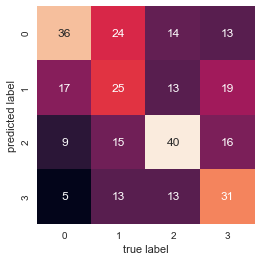

In [11]:
# Matrice de confusion pour analyse des résultats 
mat = confusion_matrix(Test_Classique['label_num'], ypred_classique1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## 1) Random Forest - Progressif

In [12]:
model = RandomForestClassifier()
model.fit(Train_Progressif['data'],Train_Progressif['label_num'])
ypred_progressif2 = model.predict(Test_Progressif['data'])

In [13]:
print(metrics.classification_report(ypred_progressif2, Test_Progressif['label_num']))

             precision    recall  f1-score   support

          0       0.55      0.49      0.52        81
          1       0.42      0.41      0.42        76
          2       0.46      0.46      0.46        83
          3       0.51      0.60      0.55        60

avg / total       0.48      0.48      0.48       300



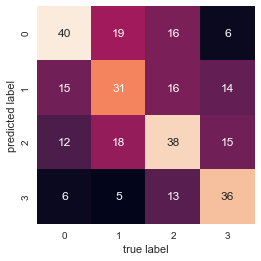

In [14]:
# Matrice de confusion 
mat = confusion_matrix(Test_Progressif['label_num'], ypred_progressif2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

##  2) Decision tree - Classic

In [35]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


In [36]:
Decision = DecisionTreeClassifier()
Decision.fit(Train_Classique['data'], Train_Classique['label_num'])
ypred_classique2 = Decision.predict(Test_Classique['data'])

In [37]:
print(metrics.classification_report(ypred_classique3, Test_Classique['label_num']))

             precision    recall  f1-score   support

          0       0.57      0.54      0.55        70
          1       0.38      0.41      0.39        71
          2       0.59      0.48      0.53        98
          3       0.48      0.59      0.53        64

avg / total       0.51      0.50      0.50       303



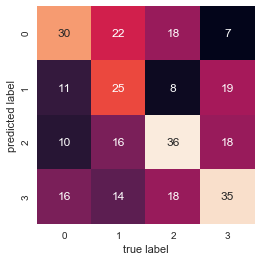

In [38]:
mat = confusion_matrix(Test_Classique['label_num'], ypred_classique2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

##  2) Decision tree - Progressif

In [42]:
Decision = DecisionTreeClassifier()
Decision.fit(Train_Progressif['data'], Train_Progressif['label_num'])
ypred_progressif2 = Decision.predict(Test_Progressif['data'])

In [43]:
print(metrics.classification_report(ypred_progressif2, Test_Progressif['label_num']))

             precision    recall  f1-score   support

          0       0.42      0.46      0.44        68
          1       0.48      0.44      0.46        80
          2       0.39      0.39      0.39        82
          3       0.30      0.30      0.30        70

avg / total       0.40      0.40      0.40       300



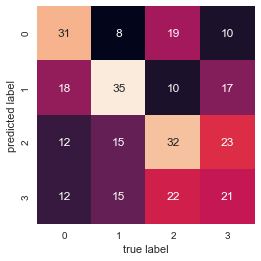

In [44]:
mat = confusion_matrix(Test_Progressif['label_num'], ypred_progressif2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## 3) Logistic Regression - Classique 

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

In [27]:
# Logistic Regression : uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’
# Essayer une version 1 vs. all par la suite 
regr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
regr.fit(Train_Classique['data'], Train_Classique['label_num']) # Train the model using Train Classique 
ypred_classique3 = regr.predict(Test_Classique['data'])

In [28]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Test_Classique['label_num'], ypred_classique3))
# Explained variance score: 
print('Variance score: %.2f' % r2_score(Test_Classique['label_num'], ypred_classique3))



Coefficients: 
 [[ 0.00000000e+00 -8.50044761e-06  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.20998797e-05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.18255019e-05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.22517462e-06  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Mean squared error: 1.15
Variance score: 0.05


In [29]:
print(metrics.classification_report(ypred_classique3, Test_Classique['label_num']))

             precision    recall  f1-score   support

          0       0.57      0.54      0.55        70
          1       0.38      0.41      0.39        71
          2       0.59      0.48      0.53        98
          3       0.48      0.59      0.53        64

avg / total       0.51      0.50      0.50       303



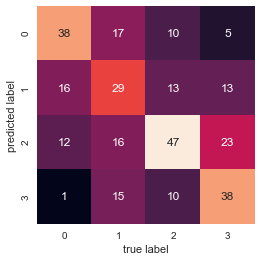

In [30]:
# Matrice de confusion 

mat = confusion_matrix(Test_Classique['label_num'], ypred_classique3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## 4) Mieux qu'un Logistic Regression =>Linear Discriminant 

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [46]:
discri = LinearDiscriminantAnalysis()
discri.fit(Train_Classique['data'], Train_Classique['label_num']) # Train the model using Train Classique 
ypred_classique4 = regr.predict(Test_Classique['data'])

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [47]:
print(metrics.classification_report(ypred_classique4, Test_Classique['label_num']))

             precision    recall  f1-score   support

          0       0.57      0.54      0.55        70
          1       0.38      0.41      0.39        71
          2       0.59      0.48      0.53        98
          3       0.48      0.59      0.53        64

avg / total       0.51      0.50      0.50       303



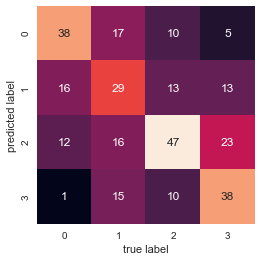

In [48]:
# Matrice de confusion 

mat = confusion_matrix(Test_Classique['label_num'], ypred_classique4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');